### Imports

Esta célula de código faz as importações necessária para o funcionamento do projeto

- **os**: Permite a manipulação de sistema de ficheiros e operações em pastas
- **shuntil**: Fornece várias operações, como copiar, mover, remover pastas
- **path**: Fornece classes para manipulação de *paths*
- **numpy**: Biblioteca para manipulação de arrays e operações matemáticas
- **image_dataset_from_directory**: Utilizado para carregar um conjunto de dados de imagens a partir de uma pasta
- **keras,layers, models**: Submódulos do Keras, utilizados para construir arquiteturas de modelos de redes neuronais
- **tensorflow**: Biblioteca de código *open-source*, para computação numérica e implementação de algoritmos de aprendizagem
- **VGG16**: Arquitetura de rede neural convolucional pré-treinada
- **EarlyStopping**: Callback para utilizar durante o treino dos modelos para interromper o processo caso não exista melhorias métricas
- **ModelCheckpoint**: Callback para utilizar durante o treino dos modelos para guardar o processo caso não exista melhorias métricas
- **matplotlib**: Biblioteca para criar gráficos e visualizações que ajudam na análise dos resultados do treino dos modelos

In [2]:
#imports
import os, shutil
from pathlib import Path
import numpy as np
import matplotlib.pyplot as plt

import tensorflow as tf
from tensorflow import keras
from keras import layers, models
from keras.utils import image_dataset_from_directory
from tensorflow.keras.applications.vgg16 import VGG16
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint

2024-06-22 20:01:30.451302: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-06-22 20:01:32.037957: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


### Reunir as imagens
**Atenção**: esta célula de código só é necessaria correr uma vez, apesar de estar em todos os *notebooks*

Nesta célula de código, fazemos a junção de todas as imagens das pastas de treino (*train1*, *train3*, *train4*, *train5*) numa só pasta, chamada de "temp_train", que vai conter todo o conteudo das pastas de treino, assim tendo um dataset único com bastantes imagens.


In [ ]:
# Lista de subpastas (train1, train3, etc.)
subfolders = ['train1', 'train3', 'train4', 'train5']

# Criar a estrutura temporária
Path(temp_train_dir).mkdir(parents=True, exist_ok=True)

# Iterar sobre cada subpasta
for subfolder in subfolders:
    subfolder_path = os.path.join(train_dir, subfolder)

    for class_folder in os.listdir(subfolder_path):
        class_folder_path = os.path.join(subfolder_path, class_folder)

        if os.path.isdir(class_folder_path):
            # Caminho destino para mover os arquivos
            dest_path = os.path.join(temp_train_dir, class_folder)

            if not os.path.exists(dest_path):
                os.makedirs(dest_path)

            # Mover todos os arquivos da subpasta para a pasta destino
            for filename in os.listdir(class_folder_path):
                file_path = os.path.join(class_folder_path, filename)
                shutil.copy(file_path, dest_path)

### Carregar as imagens

Esta célula de código define váriaveis aos caminhos das diretorias

Após ser "corrido" a célula de código acima, é possivel carregar a nova pasta chamada de temp_train juntamente com as pastas de validação, e de testes.


In [3]:
temp_train_dir = 'temp_train'
validation_dir = 'train2'
test_dir = 'test'

### Definir tamanho de imagem e tamanho de batch

Nesta célula de código é definido:
- Uma IMG_SIZE = 150, sendo assim, define o tamanho da imagem para 150x150 pixeis
- Um BATCH_SIZE = 32, que define o tamanho do lote de dados que serão "alimentados" no modelo durante o treino.
- O conjunto de dados dos diferentes datasets, nomeadamente o temp_train_dir, o validation_dir e o test_dir.
- O label_mode como categorical, pois sendo o nosso problema de classificação, é o mais indicado.

In [4]:
IMG_SIZE = 150
BATCH_SIZE = 32

train_dataset = image_dataset_from_directory(
  temp_train_dir,
  image_size=(IMG_SIZE, IMG_SIZE),
  batch_size=BATCH_SIZE,
  label_mode='categorical')

validation_dataset = image_dataset_from_directory(
  validation_dir,
  image_size=(IMG_SIZE, IMG_SIZE),
  batch_size=BATCH_SIZE,
  label_mode='categorical')

test_dataset = image_dataset_from_directory(
  test_dir,
  image_size=(IMG_SIZE, IMG_SIZE),
  batch_size=BATCH_SIZE,
  label_mode='categorical')

Found 40000 files belonging to 10 classes.


2024-06-22 20:01:40.713492: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:984] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2024-06-22 20:01:40.892255: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:984] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2024-06-22 20:01:40.892318: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:984] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2024-06-22 20:01:40.895727: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:984] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2024-06-22 20:01:40.895795: I external/local_xla/xla/stream_executor

Found 10000 files belonging to 10 classes.
Found 10000 files belonging to 10 classes.


Found 40000 files belonging to 10 classes.

Found 10000 files belonging to 10 classes.

Found 10000 files belonging to 10 classes.

### Carregar a arquitetura VGG16

Esta célula de código carrega a arquitetura da rede neural convolucional VGG16 pré-treinada e congela os seus pesos.

In [5]:
conv_base = VGG16(weights='imagenet', include_top=False)

conv_base.trainable = False

### Aplicamos a *data augmentation*

- **layers.RandomFlip("horizontal")** - é aplicado uma rotação horizontal aleatória às imagens
- **layers.RandomRotation(0.1)** - é aplicação uma rotação aleatória às imagens, dentro de um intervalo (no caso 0.1 = 10%)
- **layers.RandomZoom(0.2)** - é feito um zoom aleatorio as imagens dentro de um intervalo (no caso 0.2 = 20%)

### Construir o modelo

Neste código definimos:

- A entrada do modelo com a altura 150, a largura 150, e o RGB com 3 (os três canais de cor).
- Utilizamos a função keras.applications.vgg16.preprocess_input para pré-processar os inputs de acordo com os requisitos do VGG16.
- Passamos os inputs pré-processados pela base convolucional do VGG16, que extrai características das imagens.
- De seguida com o **layers.Flatten()(x)** transformamos os dados de saida das camadas convulacionais num vetor unidimensional.
- Com o **layers.Dense(512, activation="relu")(x)** adicionamos uma camada com 512 unidades e a função **relu**, isto permite que a rede aprenda combinações mais complexas das caracteristicas extraidas.
- Depois com o **layers.Dense(10,activation="softmax")(x)** definimos a camada de saida, com 10 unidades (número de sub-pastas em cada pasta de treino), e ainda utilizamos a ativação **softmax** que normalmente usada para problemas de classificação.
- Por fim, criamos o novo modelo com o **keras.Model(inputs=inputs, outputs=outputs)**, onde os *inputs* são as camadas de entrada e os *outputs* são as camadas de saida anteriormente definidas

In [6]:
data_augmentation = keras.Sequential(
    [
        layers.RandomFlip("horizontal"),
        layers.RandomRotation(0.1),
        layers.RandomZoom(0.2),
    ]
)

inputs = keras.Input(shape=(150, 150, 3))
x = data_augmentation(inputs)
x = keras.applications.vgg16.preprocess_input(x)
x = conv_base(x)
x = layers.Flatten()(x)
x = layers.Dense(256)(x)
x = layers.Dropout(0.5)(x)
outputs = layers.Dense(10, activation="softmax")(x)
model = keras.Model(inputs, outputs)

### Compilar e treinar o modelo

Nesta célula de código, configuramos o processo de compilação do modelo construido anteriormente.

- **loss='categorical_crossentropy'** utilizamos a função de perda 'categorical_crossentropy', pois é uma função utilizada normalmente em problemas de classificação
- **optimizer=tf.keras.optimizers.RMSprop** aqui escolhemos o otimizador RMSprop
-  **metrics=['accuracy']** por fim, definimos a métrica para avaliar o desempenho do modelo durante o treino para ser a *accuracy* 

Nesta célula de código implementamos:
- Definimos o model_checkpoint para este guardar **apenas** os melhores resultados, conforme o valor da 'val_loss'. Este guarda o melhor resultado dentro da pasta 'models' com o nome adequado.

- Iniciamos o treino do modelo com o conjunto de dados de treinamento, definido ainda o número de epochs como 30, e avaliando o mesmo com o conjunto de dados de validaçao.

Por fim a avaliação do modelo

Aqui é representado o val_acc do modelo criado na célula de código anterior, este representa o valor da precisão da classificasão do conjunto de dados de validação

In [8]:
model.compile(
    loss='categorical_crossentropy',
    optimizer='rmsprop',
    metrics=['accuracy'])

model_checkpoint = ModelCheckpoint(
    filepath='models/Projeto_T_com_data_augmentation_antes_fine_tuning_best.keras',
    save_best_only=True,
    monitor='val_loss'
)

history = model.fit(
    train_dataset,
    epochs=30,
    validation_data=(validation_dataset),
    callbacks=[model_checkpoint])

val_loss, val_acc = model.evaluate(validation_dataset)
print('Validation accuracy before fine-tuning:', val_acc)


Epoch 1/30


2024-06-21 23:30:45.445273: I external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:465] Loaded cuDNN version 8907
2024-06-21 23:30:46.016003: W external/local_tsl/tsl/framework/bfc_allocator.cc:296] Allocator (GPU_0_bfc) ran out of memory trying to allocate 1.02GiB with freed_by_count=0. The caller indicates that this is not a failure, but this may mean that there could be performance gains if more memory were available.
2024-06-21 23:30:46.120495: W external/local_tsl/tsl/framework/bfc_allocator.cc:296] Allocator (GPU_0_bfc) ran out of memory trying to allocate 828.81MiB with freed_by_count=0. The caller indicates that this is not a failure, but this may mean that there could be performance gains if more memory were available.
2024-06-21 23:30:46.248724: W external/local_tsl/tsl/framework/bfc_allocator.cc:296] Allocator (GPU_0_bfc) ran out of memory trying to allocate 3.04GiB with freed_by_count=0. The caller indicates that this is not a failure, but this may mean that there could 

1250/1250 ━━━━━━━━━━━━━━━━━━━━ 144s 111ms/step - accuracy: 0.6606 - loss: 17.4456 - val_accuracy: 0.8163 - val_loss: 3.8106
Epoch 2/30
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 139s 111ms/step - accuracy: 0.7309 - loss: 4.8014 - val_accuracy: 0.7955 - val_loss: 2.5321
Epoch 3/30
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 139s 111ms/step - accuracy: 0.7378 - loss: 3.1499 - val_accuracy: 0.8250 - val_loss: 1.9520
Epoch 4/30
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 140s 112ms/step - accuracy: 0.7473 - loss: 3.0643 - val_accuracy: 0.8065 - val_loss: 2.4714
Epoch 5/30
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 139s 111ms/step - accuracy: 0.7559 - loss: 3.1742 - val_accuracy: 0.8140 - val_loss: 2.3942
Epoch 6/30
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 140s 112ms/step - accuracy: 0.7528 - loss: 3.3718 - val_accuracy: 0.8353 - val_loss: 2.3623
Epoch 7/30
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 137s 110ms/step - accuracy: 0.7564 - loss: 3.5997 - val_accuracy: 0.8365 - val_loss: 2.4077
Epoch 8/30
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 136s 109ms/step - accuracy: 0.

Epoch 1/30
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 144s 111ms/step - accuracy: 0.6606 - loss: 17.4456 - val_accuracy: 0.8163 - val_loss: 3.8106

Epoch 2/30
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 139s 111ms/step - accuracy: 0.7309 - loss: 4.8014 - val_accuracy: 0.7955 - val_loss: 2.5321

Epoch 3/30
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 139s 111ms/step - accuracy: 0.7378 - loss: 3.1499 - val_accuracy: 0.8250 - val_loss: 1.9520

Epoch 4/30
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 140s 112ms/step - accuracy: 0.7473 - loss: 3.0643 - val_accuracy: 0.8065 - val_loss: 2.4714

Epoch 5/30
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 139s 111ms/step - accuracy: 0.7559 - loss: 3.1742 - val_accuracy: 0.8140 - val_loss: 2.3942

Epoch 6/30
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 140s 112ms/step - accuracy: 0.7528 - loss: 3.3718 - val_accuracy: 0.8353 - val_loss: 2.3623

Epoch 7/30
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 137s 110ms/step - accuracy: 0.7564 - loss: 3.5997 - val_accuracy: 0.8365 - val_loss: 2.4077

Epoch 8/30
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 136s 109ms/step - accuracy: 0.7623 - loss: 3.6094 - val_accuracy: 0.8323 - val_loss: 2.5454

Epoch 9/30
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 134s 107ms/step - accuracy: 0.7648 - loss: 3.7587 - val_accuracy: 0.8464 - val_loss: 2.4247

Epoch 10/30
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 135s 108ms/step - accuracy: 0.7687 - loss: 3.8357 - val_accuracy: 0.8344 - val_loss: 2.7357

Epoch 11/30
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 136s 109ms/step - accuracy: 0.7731 - loss: 3.8723 - val_accuracy: 0.8485 - val_loss: 2.8825

Epoch 12/30
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 135s 108ms/step - accuracy: 0.7710 - loss: 4.0220 - val_accuracy: 0.8578 - val_loss: 2.7527

Epoch 13/30
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 135s 108ms/step - accuracy: 0.7720 - loss: 4.1280 - val_accuracy: 0.8369 - val_loss: 3.2192

Epoch 14/30
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 132s 106ms/step - accuracy: 0.7747 - loss: 4.1878 - val_accuracy: 0.8286 - val_loss: 3.3234

Epoch 15/30
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 135s 108ms/step - accuracy: 0.7744 - loss: 4.2308 - val_accuracy: 0.8479 - val_loss: 3.2814

Epoch 16/30
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 140s 112ms/step - accuracy: 0.7808 - loss: 4.2402 - val_accuracy: 0.8430 - val_loss: 3.2708

Epoch 17/30
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 141s 113ms/step - accuracy: 0.7768 - loss: 4.3914 - val_accuracy: 0.8406 - val_loss: 3.3594

Epoch 18/30
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 141s 112ms/step - accuracy: 0.7801 - loss: 4.4629 - val_accuracy: 0.8394 - val_loss: 3.3827

Epoch 19/30
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 140s 112ms/step - accuracy: 0.7839 - loss: 4.4030 - val_accuracy: 0.8429 - val_loss: 3.4545

Epoch 20/30
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 141s 113ms/step - accuracy: 0.7804 - loss: 4.6157 - val_accuracy: 0.8383 - val_loss: 3.8052

Epoch 21/30
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 141s 113ms/step - accuracy: 0.7826 - loss: 4.6002 - val_accuracy: 0.8488 - val_loss: 3.0923

Epoch 22/30
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 142s 114ms/step - accuracy: 0.7811 - loss: 4.5716 - val_accuracy: 0.8369 - val_loss: 3.6566

Epoch 23/30
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 140s 112ms/step - accuracy: 0.7841 - loss: 4.6508 - val_accuracy: 0.8455 - val_loss: 3.7020

Epoch 24/30
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 141s 113ms/step - accuracy: 0.7891 - loss: 4.6658 - val_accuracy: 0.8382 - val_loss: 3.6153

Epoch 25/30
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 142s 114ms/step - accuracy: 0.7851 - loss: 4.7263 - val_accuracy: 0.8432 - val_loss: 3.5605

Epoch 26/30
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 138s 111ms/step - accuracy: 0.7867 - loss: 4.8001 - val_accuracy: 0.8525 - val_loss: 3.6507

Epoch 27/30
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 137s 110ms/step - accuracy: 0.7911 - loss: 4.8153 - val_accuracy: 0.8537 - val_loss: 3.4443

Epoch 28/30
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 135s 108ms/step - accuracy: 0.7906 - loss: 4.8237 - val_accuracy: 0.8433 - val_loss: 3.8902

Epoch 29/30
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 138s 111ms/step - accuracy: 0.7841 - loss: 4.8982 - val_accuracy: 0.8471 - val_loss: 4.3851

Epoch 30/30
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 139s 112ms/step - accuracy: 0.7901 - loss: 5.0090 - val_accuracy: 0.8537 - val_loss: 3.5197

313/313 ━━━━━━━━━━━━━━━━━━━━ 27s 85ms/step - accuracy: 0.8584 - loss: 3.4257
Validation accuracy before fine-tuning: 0.8536999821662903

### Guardar o modelo criado

Guardamos o módelo com um nome apropriado, dentro da pasta 'models'

In [10]:
model.save('models/Projeto_T_com_data_augmentation_antes_fine_tuning.keras')

### Desenhar graficos

É gerado os gráficos com os modelos previamente treinados, neste caso são os graficos antes do fine-tuning.

Os graficos mostram a accuracy e a loss, durante o processo de treino e validação ao longo das *epochs*, possibilitando ver o desempenho e o *overfitting*.

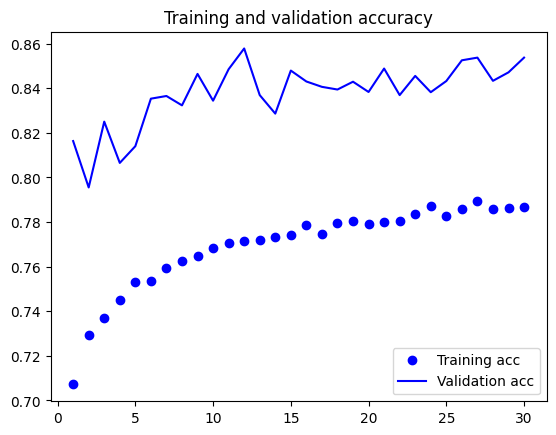

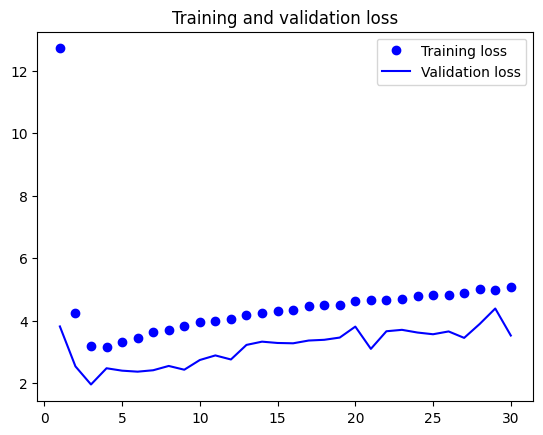

In [11]:
import matplotlib.pyplot as plt

acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs = range(1, len(acc) + 1)

plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.legend()
plt.figure()
plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()
plt.show()

### Ajustar a base convucional VGG16

Nesta célula de código começamos por obter a layer VGG16

De seguinda congelamos as primeiras camadas da base convolucional para preservar os pesos pré-treinados, deixando apenas as últimas quatro camadas treináveis

Ainda fazemos um print para poder observar os resultados

In [12]:
convbase = model.get_layer("vgg16")

convbase.trainable = True

for layer in convbase.layers[:-4]:
    layer.trainable = False

for i, layer in enumerate(convbase.layers):
    print(i, layer.name, layer.trainable)

0 input_layer False
1 block1_conv1 False
2 block1_conv2 False
3 block1_pool False
4 block2_conv1 False
5 block2_conv2 False
6 block2_pool False
7 block3_conv1 False
8 block3_conv2 False
9 block3_conv3 False
10 block3_pool False
11 block4_conv1 False
12 block4_conv2 False
13 block4_conv3 False
14 block4_pool False
15 block5_conv1 True
16 block5_conv2 True
17 block5_conv3 True
18 block5_pool True


0 input_layer False

1 block1_conv1 False

2 block1_conv2 False

3 block1_pool False

4 block2_conv1 False

5 block2_conv2 False

6 block2_pool False

7 block3_conv1 False

8 block3_conv2 False

9 block3_conv3 False

10 block3_pool False

11 block4_conv1 False

12 block4_conv2 False

13 block4_conv3 False

14 block4_pool False

15 block5_conv1 True

16 block5_conv2 True

17 block5_conv3 True

18 block5_pool True

### Compilar e treinar o modelo APOS o fine-tuning

Nesta célula de código voltamos a fazer o treino, mas desta vez, com o fine-tuning aplicado, para gerar resultados melhores

In [22]:
import tensorflow as tf

model.compile(
    loss='categorical_crossentropy',
    optimizer=tf.keras.optimizers.RMSprop(learning_rate=1e-4),
    metrics=['accuracy'])

model_checkpoint = ModelCheckpoint(
    filepath='models/Projeto_T_com_data_augmentation_depois_fine_tuning_best.keras',
    save_best_only=True,
    monitor='val_loss'
)

early_stopping = EarlyStopping(
    monitor='val_loss',  # Monitorar a perda na validação
    patience=5,  # Número de epochs sem melhoria para parar
    restore_best_weights=True  # Restaurar os melhores pesos ao final
)

#callbacks = [early_stopping, model_checkpoint]
callbacks = [model_checkpoint]

historyAfter = model.fit(
    train_dataset,
    epochs=30,
    validation_data=(validation_dataset),
    callbacks=callbacks)

val_loss, val_acc = model.evaluate(validation_dataset)
print('Validation accuracy after fine-tuning:', val_acc)

Epoch 1/30
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 191s 148ms/step - accuracy: 0.8546 - loss: 0.4994 - val_accuracy: 0.8865 - val_loss: 0.4257
Epoch 2/30
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 177s 142ms/step - accuracy: 0.8608 - loss: 0.4741 - val_accuracy: 0.8878 - val_loss: 0.4223
Epoch 3/30
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 174s 139ms/step - accuracy: 0.8720 - loss: 0.4374 - val_accuracy: 0.8959 - val_loss: 0.3684
Epoch 4/30
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 175s 140ms/step - accuracy: 0.8732 - loss: 0.4362 - val_accuracy: 0.8991 - val_loss: 0.4159
Epoch 5/30
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 176s 141ms/step - accuracy: 0.8776 - loss: 0.4305 - val_accuracy: 0.8840 - val_loss: 0.4528
Epoch 6/30
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 175s 140ms/step - accuracy: 0.8820 - loss: 0.4196 - val_accuracy: 0.8916 - val_loss: 0.4720
Epoch 7/30
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 175s 140ms/step - accuracy: 0.8824 - loss: 0.4244 - val_accuracy: 0.9034 - val_loss: 0.4667
Epoch 8/30
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 176s 141ms/step - ac

Epoch 1/30
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 191s 148ms/step - accuracy: 0.8546 - loss: 0.4994 - val_accuracy: 0.8865 - val_loss: 0.4257

Epoch 2/30
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 177s 142ms/step - accuracy: 0.8608 - loss: 0.4741 - val_accuracy: 0.8878 - val_loss: 0.4223

Epoch 3/30
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 174s 139ms/step - accuracy: 0.8720 - loss: 0.4374 - val_accuracy: 0.8959 - val_loss: 0.3684

Epoch 4/30
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 175s 140ms/step - accuracy: 0.8732 - loss: 0.4362 - val_accuracy: 0.8991 - val_loss: 0.4159

Epoch 5/30
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 176s 141ms/step - accuracy: 0.8776 - loss: 0.4305 - val_accuracy: 0.8840 - val_loss: 0.4528

Epoch 6/30
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 175s 140ms/step - accuracy: 0.8820 - loss: 0.4196 - val_accuracy: 0.8916 - val_loss: 0.4720

Epoch 7/30
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 175s 140ms/step - accuracy: 0.8824 - loss: 0.4244 - val_accuracy: 0.9034 - val_loss: 0.4667

Epoch 8/30
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 176s 141ms/step - accuracy: 0.8872 - loss: 0.4100 - val_accuracy: 0.8803 - val_loss: 0.5733

Epoch 9/30
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 177s 141ms/step - accuracy: 0.8850 - loss: 0.4180 - val_accuracy: 0.9000 - val_loss: 0.4422

Epoch 10/30
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 198s 158ms/step - accuracy: 0.8876 - loss: 0.4216 - val_accuracy: 0.9000 - val_loss: 0.4318

Epoch 11/30
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 190s 152ms/step - accuracy: 0.8883 - loss: 0.4025 - val_accuracy: 0.8990 - val_loss: 0.5125

Epoch 12/30
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 185s 148ms/step - accuracy: 0.8870 - loss: 0.4192 - val_accuracy: 0.8964 - val_loss: 0.5547

Epoch 13/30
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 171s 137ms/step - accuracy: 0.8926 - loss: 0.4059 - val_accuracy: 0.8937 - val_loss: 0.5775

Epoch 14/30
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 168s 134ms/step - accuracy: 0.8939 - loss: 0.4001 - val_accuracy: 0.9017 - val_loss: 0.4701

Epoch 15/30
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 168s 134ms/step - accuracy: 0.8941 - loss: 0.4108 - val_accuracy: 0.9031 - val_loss: 0.5446

Epoch 16/30
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 171s 137ms/step - accuracy: 0.8953 - loss: 0.4045 - val_accuracy: 0.9063 - val_loss: 0.4668

Epoch 17/30
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 176s 141ms/step - accuracy: 0.8979 - loss: 0.4100 - val_accuracy: 0.8974 - val_loss: 0.5941

Epoch 18/30
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 174s 139ms/step - accuracy: 0.8928 - loss: 0.4176 - val_accuracy: 0.8913 - val_loss: 0.7176

Epoch 19/30
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 175s 140ms/step - accuracy: 0.8930 - loss: 0.4162 - val_accuracy: 0.8806 - val_loss: 0.9628

Epoch 20/30
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 176s 140ms/step - accuracy: 0.8961 - loss: 0.4261 - val_accuracy: 0.8930 - val_loss: 0.5725

Epoch 21/30
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 178s 142ms/step - accuracy: 0.9048 - loss: 0.3987 - val_accuracy: 0.8772 - val_loss: 0.6939

Epoch 22/30
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 180s 144ms/step - accuracy: 0.9014 - loss: 0.4098 - val_accuracy: 0.8855 - val_loss: 0.6346

Epoch 23/30
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 181s 144ms/step - accuracy: 0.9044 - loss: 0.4035 - val_accuracy: 0.8985 - val_loss: 0.6125

Epoch 24/30
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 176s 140ms/step - accuracy: 0.9034 - loss: 0.4132 - val_accuracy: 0.8953 - val_loss: 0.7601

Epoch 25/30
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 177s 142ms/step - accuracy: 0.9044 - loss: 0.4123 - val_accuracy: 0.9042 - val_loss: 0.6626

Epoch 26/30
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 176s 141ms/step - accuracy: 0.9033 - loss: 0.4012 - val_accuracy: 0.8892 - val_loss: 0.6508

Epoch 27/30
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 177s 142ms/step - accuracy: 0.9070 - loss: 0.4034 - val_accuracy: 0.9001 - val_loss: 0.8434

Epoch 28/30
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 176s 141ms/step - accuracy: 0.9074 - loss: 0.4179 - val_accuracy: 0.8913 - val_loss: 0.7439

Epoch 29/30
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 177s 141ms/step - accuracy: 0.9068 - loss: 0.4194 - val_accuracy: 0.8867 - val_loss: 0.7930

Epoch 30/30
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 175s 140ms/step - accuracy: 0.9042 - loss: 0.4290 - val_accuracy: 0.8977 - val_loss: 0.6798

313/313 ━━━━━━━━━━━━━━━━━━━━ 27s 87ms/step - accuracy: 0.8996 - loss: 0.7452

Validation accuracy after fine-tuning: 0.8977000117301941

### Avaliação do modelo

Aqui é representado o val_acc do modelo criado na célula de código anterior, este representa o valor da precisão da classificasão do conjunto de dados de validação

In [23]:
model.save('models/Projeto_T_com_data_augmentation_depois_fine_tuning.keras')

### Desenhar graficos

É gerado os gráficos com os modelos previamente treinados, neste caso são os graficos depois do fine-tuning.

Os graficos mostram a accuracy e a loss, durante o processo de treino e validação ao longo das *epochs*, possibilitando ver o desempenho e o *overfitting*.

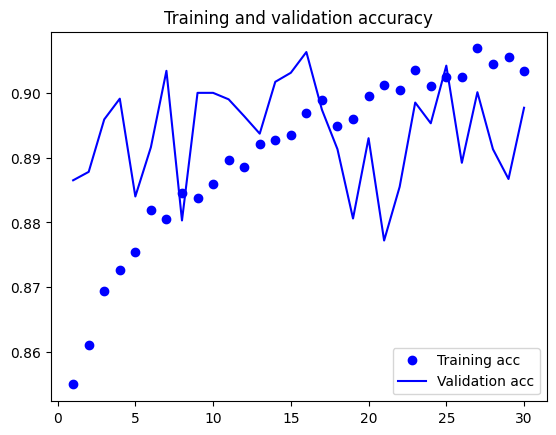

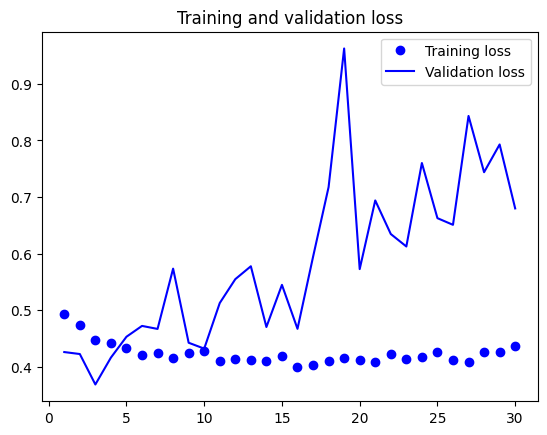

In [24]:
import matplotlib.pyplot as plt

acc = historyAfter.history['accuracy']
val_acc = historyAfter.history['val_accuracy']
loss = historyAfter.history['loss']
val_loss = historyAfter.history['val_loss']
epochs = range(1, len(acc) + 1)

plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.legend()
plt.figure()
plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()
plt.show()

### Carregar modelo

Aqui vamos carregar o modelo em que foi obtido o best, antes de realizar o fine-tuning

In [6]:
loaded_model = tf.keras.models.load_model('models/Projeto_T_com_data_augmentation_antes_fine_tuning_best.keras')


### Ajustar a base convucional VGG16 (alterar para apenas deixar duas camadas)

Nesta célula de código começamos por obter a layer VGG16

De seguinda congelamos as primeiras camadas da base convolucional para preservar os pesos pré-treinados, deixando apenas as últimas duas camadas treináveis

Ainda fazemos um print para poder observar os resultados

In [8]:
convbase = loaded_model.get_layer("vgg16")

convbase.trainable = True

for layer in convbase.layers[:-2]:
    layer.trainable = False

for i, layer in enumerate(convbase.layers):
    print(i, layer.name, layer.trainable)

0 input_layer False
1 block1_conv1 False
2 block1_conv2 False
3 block1_pool False
4 block2_conv1 False
5 block2_conv2 False
6 block2_pool False
7 block3_conv1 False
8 block3_conv2 False
9 block3_conv3 False
10 block3_pool False
11 block4_conv1 False
12 block4_conv2 False
13 block4_conv3 False
14 block4_pool False
15 block5_conv1 False
16 block5_conv2 False
17 block5_conv3 True
18 block5_pool True


0 input_layer False

1 block1_conv1 False

2 block1_conv2 False

3 block1_pool False

4 block2_conv1 False

5 block2_conv2 False

6 block2_pool False

7 block3_conv1 False

8 block3_conv2 False

9 block3_conv3 False

10 block3_pool False

11 block4_conv1 False

12 block4_conv2 False

13 block4_conv3 False

14 block4_pool False

15 block5_conv1 False

16 block5_conv2 False

17 block5_conv3 True

18 block5_pool True

### Compilar e treinar o modelo ANTES do fine-tuning MAS com apenas 2 camadas

Nesta célula de código voltamos a fazer o treino, mas desta vez, com apenas 2 camadas treinaveis

In [9]:
import tensorflow as tf

loaded_model.compile(
    loss='categorical_crossentropy',
    optimizer=tf.keras.optimizers.RMSprop(learning_rate=1e-4),
    metrics=['accuracy'])

model_checkpoint = ModelCheckpoint(
    filepath='models/Projeto_T_com_data_augmentation_depois_fine_tuning_2Freezes_best.keras',
    save_best_only=True,
    monitor='val_loss'
)

early_stopping = EarlyStopping(
    monitor='val_loss',  
    patience=5,  
    restore_best_weights=True  
)

#callbacks = [early_stopping, model_checkpoint]
callbacks = [model_checkpoint]

historyAfter2Frozen = loaded_model.fit(
    train_dataset,
    epochs=30,
    validation_data=(validation_dataset),
    callbacks=callbacks)

val_loss, val_acc = loaded_model.evaluate(validation_dataset)
print('Validation accuracy after fine-tuning:', val_acc)

Epoch 1/30


2024-06-22 20:04:08.052752: I external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:465] Loaded cuDNN version 8907


1250/1250 ━━━━━━━━━━━━━━━━━━━━ 152s 117ms/step - accuracy: 0.7680 - loss: 1.5355 - val_accuracy: 0.8683 - val_loss: 0.4730
Epoch 2/30
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 147s 118ms/step - accuracy: 0.8255 - loss: 0.5868 - val_accuracy: 0.8907 - val_loss: 0.3679
Epoch 3/30
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 144s 115ms/step - accuracy: 0.8551 - loss: 0.4637 - val_accuracy: 0.8937 - val_loss: 0.3880
Epoch 4/30
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 145s 116ms/step - accuracy: 0.8703 - loss: 0.4133 - val_accuracy: 0.9031 - val_loss: 0.3421
Epoch 5/30
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 145s 116ms/step - accuracy: 0.8837 - loss: 0.3681 - val_accuracy: 0.9037 - val_loss: 0.3478
Epoch 6/30
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 149s 119ms/step - accuracy: 0.8952 - loss: 0.3386 - val_accuracy: 0.9093 - val_loss: 0.3313
Epoch 7/30
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 148s 119ms/step - accuracy: 0.8989 - loss: 0.3179 - val_accuracy: 0.9062 - val_loss: 0.3547
Epoch 8/30
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 147s 118ms/step - accuracy: 0.9

Epoch 1/30
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 152s 117ms/step - accuracy: 0.7680 - loss: 1.5355 - val_accuracy: 0.8683 - val_loss: 0.4730

Epoch 2/30
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 147s 118ms/step - accuracy: 0.8255 - loss: 0.5868 - val_accuracy: 0.8907 - val_loss: 0.3679

Epoch 3/30
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 144s 115ms/step - accuracy: 0.8551 - loss: 0.4637 - val_accuracy: 0.8937 - val_loss: 0.3880

Epoch 4/30
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 145s 116ms/step - accuracy: 0.8703 - loss: 0.4133 - val_accuracy: 0.9031 - val_loss: 0.3421

Epoch 5/30
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 145s 116ms/step - accuracy: 0.8837 - loss: 0.3681 - val_accuracy: 0.9037 - val_loss: 0.3478

Epoch 6/30
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 149s 119ms/step - accuracy: 0.8952 - loss: 0.3386 - val_accuracy: 0.9093 - val_loss: 0.3313

Epoch 7/30
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 148s 119ms/step - accuracy: 0.8989 - loss: 0.3179 - val_accuracy: 0.9062 - val_loss: 0.3547

Epoch 8/30
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 147s 118ms/step - accuracy: 0.9043 - loss: 0.3031 - val_accuracy: 0.9096 - val_loss: 0.3542

Epoch 9/30
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 148s 118ms/step - accuracy: 0.9141 - loss: 0.2738 - val_accuracy: 0.9078 - val_loss: 0.3643

Epoch 10/30
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 143s 114ms/step - accuracy: 0.9175 - loss: 0.2705 - val_accuracy: 0.9116 - val_loss: 0.3482

Epoch 11/30
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 144s 115ms/step - accuracy: 0.9222 - loss: 0.2517 - val_accuracy: 0.9172 - val_loss: 0.3480

Epoch 12/30
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 144s 115ms/step - accuracy: 0.9254 - loss: 0.2420 - val_accuracy: 0.9173 - val_loss: 0.3607

Epoch 13/30
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 147s 118ms/step - accuracy: 0.9277 - loss: 0.2382 - val_accuracy: 0.9115 - val_loss: 0.3686

Epoch 14/30
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 148s 118ms/step - accuracy: 0.9316 - loss: 0.2251 - val_accuracy: 0.9131 - val_loss: 0.3677

Epoch 15/30
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 144s 115ms/step - accuracy: 0.9358 - loss: 0.2138 - val_accuracy: 0.9154 - val_loss: 0.3895

Epoch 16/30
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 145s 116ms/step - accuracy: 0.9369 - loss: 0.2061 - val_accuracy: 0.9135 - val_loss: 0.4083

Epoch 17/30
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 144s 116ms/step - accuracy: 0.9381 - loss: 0.2021 - val_accuracy: 0.9084 - val_loss: 0.4340

Epoch 18/30
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 143s 115ms/step - accuracy: 0.9417 - loss: 0.2081 - val_accuracy: 0.9146 - val_loss: 0.4288

Epoch 19/30
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 142s 114ms/step - accuracy: 0.9425 - loss: 0.1958 - val_accuracy: 0.9138 - val_loss: 0.4218

Epoch 20/30
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 143s 115ms/step - accuracy: 0.9480 - loss: 0.1785 - val_accuracy: 0.9165 - val_loss: 0.4315

Epoch 21/30
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 146s 117ms/step - accuracy: 0.9496 - loss: 0.1711 - val_accuracy: 0.9172 - val_loss: 0.4588

Epoch 22/30
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 161s 129ms/step - accuracy: 0.9523 - loss: 0.1702 - val_accuracy: 0.9186 - val_loss: 0.4517

Epoch 23/30
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 159s 127ms/step - accuracy: 0.9524 - loss: 0.1674 - val_accuracy: 0.9181 - val_loss: 0.4331

Epoch 24/30
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 175s 140ms/step - accuracy: 0.9533 - loss: 0.1627 - val_accuracy: 0.9123 - val_loss: 0.5041

Epoch 25/30
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 435s 348ms/step - accuracy: 0.9534 - loss: 0.1671 - val_accuracy: 0.9192 - val_loss: 0.4474

Epoch 26/30
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 184s 147ms/step - accuracy: 0.9574 - loss: 0.1554 - val_accuracy: 0.9161 - val_loss: 0.5438

Epoch 27/30
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 235s 188ms/step - accuracy: 0.9578 - loss: 0.1539 - val_accuracy: 0.9170 - val_loss: 0.4966

Epoch 28/30
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 240s 192ms/step - accuracy: 0.9579 - loss: 0.1586 - val_accuracy: 0.9134 - val_loss: 0.5465

Epoch 29/30
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 155s 124ms/step - accuracy: 0.9587 - loss: 0.1508 - val_accuracy: 0.9129 - val_loss: 0.5566

Epoch 30/30
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 159s 127ms/step - accuracy: 0.9613 - loss: 0.1470 - val_accuracy: 0.9180 - val_loss: 0.5153

313/313 ━━━━━━━━━━━━━━━━━━━━ 28s 88ms/step - accuracy: 0.9168 - loss: 0.5340

Validation accuracy after fine-tuning: 0.9179999828338623

### Guardar novo modelo

In [ ]:
model.save('models/Projeto_T_com_data_augmentation_depois_fine_tuning_2Freezes.keras')

### Desenhar graficos (novos com apenas 2 camadas treinaveis)

É gerado os gráficos com os modelos previamente treinados, neste caso são os graficos depois do fine-tuning.

Os graficos mostram a accuracy e a loss, durante o processo de treino e validação ao longo das *epochs.

In [ ]:
import matplotlib.pyplot as plt

acc = historyAfter2Frozen.history['accuracy']
val_acc = historyAfter2Frozen.history['val_accuracy']
loss = historyAfter2Frozen.history['loss']
val_loss = historyAfter2Frozen.history['val_loss']
epochs = range(1, len(acc) + 1)

plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.legend()
plt.figure()
plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()
plt.show()

### Relatório

#### Objetivo

Neste *notebook* desenvolvemos uma rede convolucional com Transfer Learning e técnicas de Transfer Learning numa tentativa de melhorar as precisões e resolver os problemas de *overfitting*:

- **Camada de entrada:** Recebe imagens de dimensão 150x150 pixels e 3 canais de cor (RGB).
- **Camada de pré-processamento:** Realiza operações de obtenção de itens e empilhamento.
- **Camada VGG16:** Convolucional pré-treinada com saída de dimensão 4x4x512.
- **Camada flatten:** Transforma a saída da VGG16 em uma única dimensão (8192).
- **Camada fully connected (Dense):** 256 unidades, seguida de uma camada de dropout com taxa de 50%.
- **Camada de saída (Dense):** 10 unidades para classificação, usando softmax como função de ativação.

#### Desenvolvimento

Desenvolvemos a seguinte rede:

| Layer (type)       | Output Shape     |    Param # | Connected to      |
|--------------------|------------------|------------|-------------------|
| input_layer_1      | (None, 150, 150, |          0 | -                 |
| (InputLayer)       | 3)               |            |                   |
| get_item (GetItem) | (None, 150, 150) |          0 | input_layer_1[0][0] |
| get_item_1         | (None, 150, 150) |          0 | input_layer_1[0][0] |
| (GetItem)          |                  |            |                   |
| get_item_2         | (None, 150, 150) |          0 | input_layer_1[0][0] |
| (GetItem)          |                  |            |                   |
| stack (Stack)      | (None, 150, 150, |          0 | get_item[0][0],   |
|                    | 3)               |            | get_item_1[0][0], |
|                    |                  |            | get_item_2[0][0]  |
| add (Add)          | (None, 150, 150, |          0 | stack[0][0]       |
|                    | 3)               |            |                   |
| vgg16 (Functional) | (None, 4, 4, 512)| 14,714,688 | add[0][0]         |
| flatten (Flatten)  | (None, 8192)     |          0 | vgg16[0][0]       |
| dense (Dense)      | (None, 256)      |  2,097,408 | flatten[0][0]     |
| dropout (Dropout)  | (None, 256)      |          0 | dense[0][0]       |
| dense_1 (Dense)    | (None, 10)       |      2,570 | dropout[0][0]     |


Neste modelo foi aplicado o conceito de ***transfer learning***, isto é, a utilização de um modelo pré-treinado e adaptado para o nosso problema de classificação.

Foi também utilizado ***data augmentation***, isto são, as imagens do conjunto de treino transformadas com rotações horizontais aleatórias e *zooms*, geradas no momento em que é executada a rede para aumentar a variedade do conjunto de dados de treino e assim impedir que a rede se acostume aos dados de treino e obtenha melhores resultados na classificação dos dados de validação. 

Para além disso, usamos também o ***fine tuning*** que é uma técnica utilizada no *transfer learning* para "afinar" o modelo congelando as camadas convolucionais do modelo pré-treinado. Com isto obtemos os seguintes resultados:

- **antes do fine tuning:**

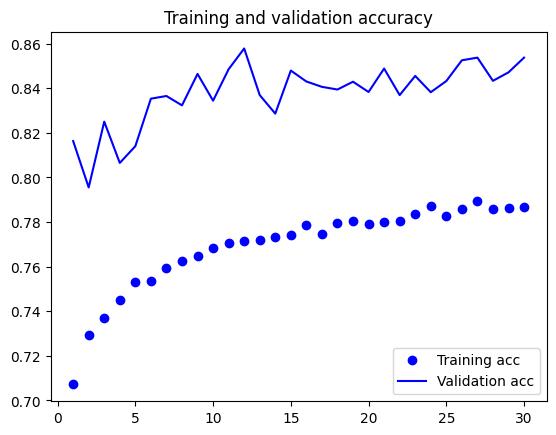

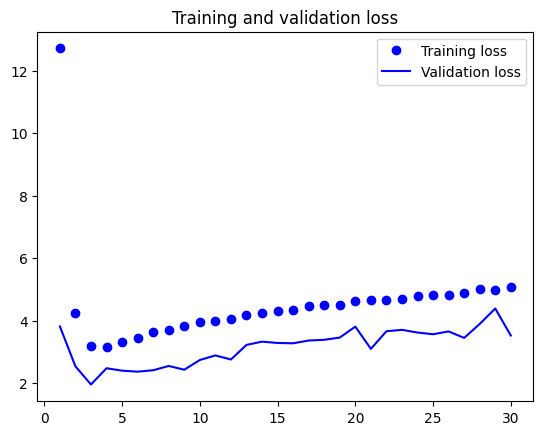

**val_acc:** 0.8536999821662903

- **depois do fine tuning, com apenas 4 camadas treinaveis:**

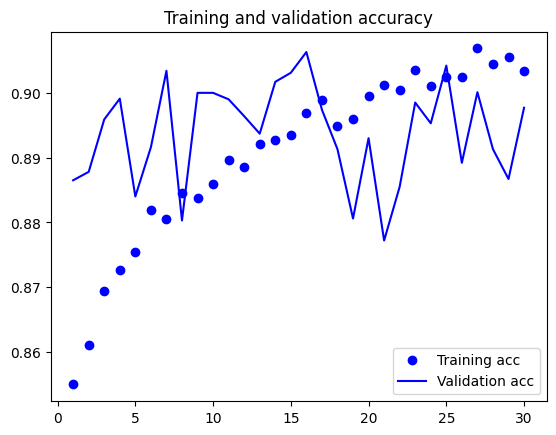

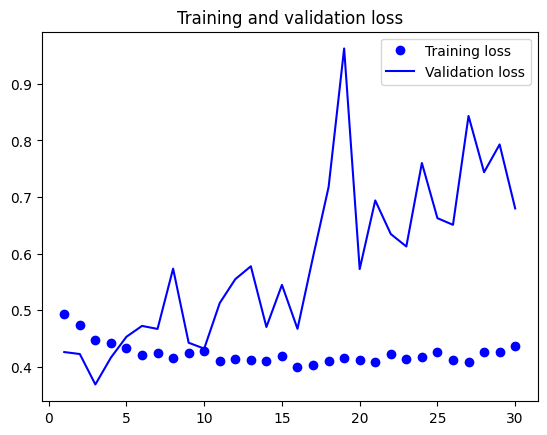

**val_acc:** 0.8977000117301941

- **depois do fine tuning, com apenas 2 camadas treinaveis:**

**val_acc:** 0.9179999828338623

#### Conclusão

Como podemos concluir a partir dos gráficos apresentados, os valores de precisão da classificação do conjunto de dados de validação, com o uso de *transfer learning* e *data augmentation* melhoraram, alcançado praticamente os 90%.